In [1]:
import torch 
import numpy as np
import pandas as pd 
import utilities
from math import ceil
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.autograd import Variable

In [2]:
fin_df = utilities.financial_dataset(stock='NVDA', num_of_labels=2, start_date='2011-02-01', end_date='2020-06-20')
fin_df

[*********************100%***********************]  1 of 1 completed
NVDA financial dataframe dimensions  (2363, 6)
Positive changes : 1228
Negative changes : 1135
No changes : 0


,Open,Close,Volume,Price_change,date
Date,,,,,
2011-01-31,5.950000,5.980000,75016000,1,0
2011-02-01,6.032500,6.117500,65410400,1,2011-02-01
2011-02-02,6.082500,6.395000,160661600,1,2011-02-02
2011-02-03,6.405000,6.275000,103077600,-1,2011-02-03
2011-02-04,6.362500,6.417500,87290000,1,2011-02-04
...,...,...,...,...,...
2020-06-15,88.152496,91.737503,40000400,1,2020-06-15
2020-06-16,92.250000,90.684998,53571600,-1,2020-06-16
2020-06-17,91.137497,92.360001,40830400,1,2020-06-17


### Pre-process dataset
Create small time series of 30 days. So for every 30 days' close prices $X_{it}$ we have a label price $y_t$ which is the closing price of 31st day.

In [3]:
seq_len = 60
# start creating sequences only after the first seq_len elements have passed 
X = np.zeros((fin_df.shape[0] - seq_len, seq_len))
y = np.zeros((fin_df.shape[0] - seq_len, 1))
print("X shape :",X.shape)
print("y shape :",y.shape)

X shape : (2303, 60)
y shape : (2303, 1)


In [4]:
for i in range(seq_len , X.shape[0] + seq_len) :
    prev_elems = fin_df.iloc[i-seq_len : i]['Close']
    # only the desired values
    prev_elems = [ prev_elems[p] for p in range(len(prev_elems))]
    prev_elems = np.array(prev_elems)
    # Store previous 30 days close price
    X[i-seq_len] = prev_elems
    # Store label, close price of day 31 
    y[i-seq_len] = fin_df.iloc[i]['Close']

### Normalise dataset and split into train-test.
Min - Max scaling 

In [5]:
# transform features with standard scaler, and output values (close prices) to [0,1] with minmax scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
#ss = StandardScaler()

X_mm = mm.fit_transform(X)
y_mm = mm.fit_transform(np.array(y).reshape(-1, 1))

Data splitting into train, test . 

In [6]:
# fraction of the test set.
percentage = 0.25
split = ceil(X_mm.shape[0] *(1-percentage))
X_train = X_mm[0:split]
y_train = y_mm[0:split]
X_test= X_mm[split:]
y_test= y_mm[split:]
print(f"Train data shapes X:{X_train.shape} , y:{y_train.shape}")
print(f"Train data shapes X:{X_test.shape} , y:{y_test.shape}")

Train data shapes X:(1728, 60) , y:(1728, 1)
Train data shapes X:(575, 60) , y:(575, 1)


### Convert np.arrays into tensors and reshape in the format expected by the LSTM .

In [7]:
X_tensors = Variable(torch.Tensor(X_mm))
y_tensors = Variable(torch.Tensor(y_mm))
#reshaping to rows, timestamps, features
X_tensors = torch.reshape(X_tensors,   (X_tensors.shape[0], 1, X_tensors.shape[1]))
y_tensors = torch.reshape(y_tensors,  (y_tensors.shape[0], 1, y_tensors.shape[1]))


In [8]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [9]:
#reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([1728, 1, 60]) torch.Size([1728, 1])
Testing Shape torch.Size([575, 1, 60]) torch.Size([575, 1])


### Define LSTM structure .
The LSTM will execute regression, so MSE loss is need during training. 

In [10]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [11]:
#hyperparameters
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = seq_len #number of features
hidden_size = 30 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

#### Training loop

In [12]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0

  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)

  loss.backward() #calculates the loss of the loss function

  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.05053
Epoch: 100, loss: 0.00033
Epoch: 200, loss: 0.00023
Epoch: 300, loss: 0.00009
Epoch: 400, loss: 0.00006
Epoch: 500, loss: 0.00005
Epoch: 600, loss: 0.00005
Epoch: 700, loss: 0.00004
Epoch: 800, loss: 0.00004
Epoch: 900, loss: 0.00004


### Predicting with the LSTM

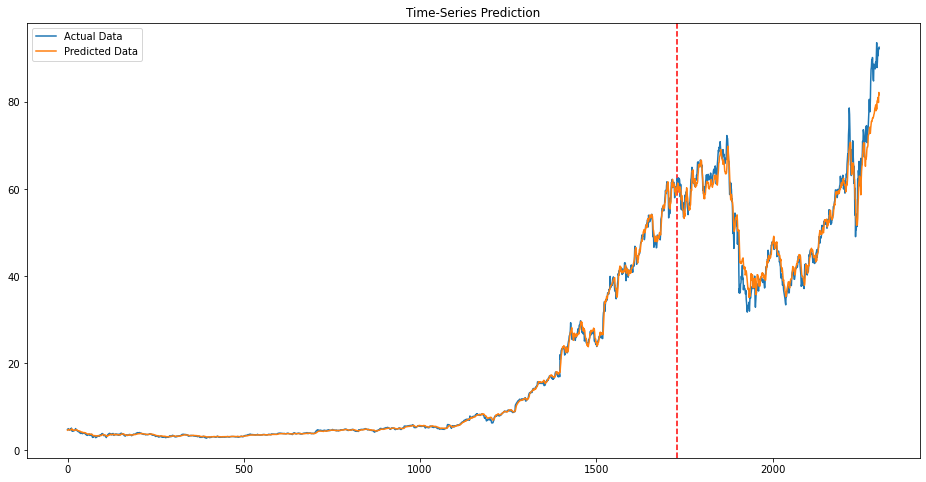

In [13]:
train_predict = lstm1(X_tensors) #forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y_tensors.data.numpy()
dataY_plot =  np.reshape(dataY_plot, (dataY_plot.shape[0],1))

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

plt.figure(figsize=(16,8)) #plotting
plt.axvline(x=split, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

### Evaluation of regression predictions with MSE and Spearman Correlation. 

In [14]:
#from sklearn.metric import mean_squared_error
mse = (np.power(dataY_plot[split:] - data_predict[split:], 2).mean())
print("TEST DATA, MSE loss : ", mse)

TEST DATA, MSE loss :  12.195044


In [15]:
#from sklearn.metric import mean_squared_error
mse = (np.power(dataY_plot[:split] - data_predict[:split], 2).mean())
print("TRAIN DATA , MSE loss : ", mse)

TRAIN DATA , MSE loss :  0.2857101


In [16]:
from scipy.stats import spearmanr
#from sklearn.metric import mean_squared_error
spearman = spearmanr(dataY_plot[split:],data_predict[split:])
print("TEST DATA,  Spreaman correlation : ", spearman)

#from sklearn.metric import mean_squared_error
spearman = spearmanr(dataY_plot[:split],data_predict[:split])
print("TRAIN DATA , Spreaman correlation : ", spearman)

TEST DATA,  Spreaman correlation :  SpearmanrResult(correlation=0.9772749505216329, pvalue=0.0)
TRAIN DATA , Spreaman correlation :  SpearmanrResult(correlation=0.9935734782721941, pvalue=0.0)


# 2.) Classification of price movement with LSTM 

## Pre-process dataset


### Price_change is the class . 0: decrease , +1 : increase

In [17]:
fin_df['Price_change'] = fin_df['Price_change'].apply(lambda x : x+1 if (x==-1) else x)
fin_df

,Open,Close,Volume,Price_change,date
Date,,,,,
2011-01-31,5.950000,5.980000,75016000,1,0
2011-02-01,6.032500,6.117500,65410400,1,2011-02-01
2011-02-02,6.082500,6.395000,160661600,1,2011-02-02
2011-02-03,6.405000,6.275000,103077600,0,2011-02-03
2011-02-04,6.362500,6.417500,87290000,1,2011-02-04
...,...,...,...,...,...
2020-06-15,88.152496,91.737503,40000400,1,2020-06-15
2020-06-16,92.250000,90.684998,53571600,0,2020-06-16
2020-06-17,91.137497,92.360001,40830400,1,2020-06-17


Create small time series of N days. So for every N days' close prices $X_{it}$ we have a label price $y_t$ which is the price movement compared to yesterday (increase or decrease in price).

In [18]:
seq_len = 30
# start creating sequences only after the first seq_len elements have passed 
X = np.zeros((fin_df.shape[0] - seq_len, seq_len))
y = np.zeros((fin_df.shape[0] - seq_len, 1))
print("X shape :",X.shape)
print("y shape :",y.shape)

X shape : (2333, 30)
y shape : (2333, 1)


In [19]:
for i in range(seq_len , X.shape[0] + seq_len) :
    prev_elems = fin_df.iloc[i-seq_len : i]['Close']
    # only the desired values
    prev_elems = [ prev_elems[p] for p in range(len(prev_elems))]
    prev_elems = np.array(prev_elems)
    # Store previous seq_len  days close price
    X[i-seq_len] = prev_elems
    # Store label, close price of day 31 
    y[i-seq_len] = fin_df.iloc[i]['Price_change']

### Normalise dataset and split into train-test.
#### Convert np.arrays into tensors and reshape in the format expected by the LSTM .
Min - Max scaling 

In [20]:
# transform features with standard scaler, and output values (close prices) to [0,1] with minmax scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
#ss = StandardScaler()

X_mm = mm.fit_transform(X)

# fraction of the test set.
percentage = 0.25
split = ceil(X_mm.shape[0] *(1-percentage))
X_train = X_mm[0:split]
y_train = y[0:split]
X_test= X_mm[split:]
y_test= y[split:]
print(f"Train data shapes X:{X_train.shape} , y:{y_train.shape}")
print(f"Train data shapes X:{X_test.shape} , y:{y_test.shape}")

### TO tensors 
###
X_tensors = Variable(torch.Tensor(X_mm))
y_tensors = Variable(torch.Tensor(y))
#reshaping to rows, timestamps, features
X_tensors = torch.reshape(X_tensors,   (X_tensors.shape[0], 1, X_tensors.shape[1]))
y_tensors = torch.reshape(y_tensors,  (y_tensors.shape[0], 1, y_tensors.shape[1]))

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

#reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Train data shapes X:(1750, 30) , y:(1750, 1)
Train data shapes X:(583, 30) , y:(583, 1)
Training Shape torch.Size([1750, 1, 30]) torch.Size([1750, 1])
Testing Shape torch.Size([583, 1, 30]) torch.Size([583, 1])


### Define classification LSTM  : We need to add a sigmoid activation function at the end in order to get output in the $[0,1]$ range.

In [21]:
class LSTM_clf(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM_clf, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
        # sigmoid activation for end classification
        self.sigm = nn.Sigmoid()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        
        out = self.sigm(out)
        return out

#### Training the LSTM . 

In [22]:
#hyperparameters
num_epochs = 5000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = seq_len #number of features
hidden_size = 60 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 2 #number of output classes

lstm_clf = LSTM_clf(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm_clf.parameters(), lr=learning_rate)

#### TRAIN LOOP ######
for epoch in range(num_epochs):
  outputs = lstm_clf.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)

  loss.backward() #calculates the loss of the loss function

  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.25009


C:\Users\Konpoul\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1750, 1])) that is different to the input size (torch.Size([1750, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 100, loss: 0.24826
Epoch: 200, loss: 0.24795
Epoch: 300, loss: 0.24721
Epoch: 400, loss: 0.24538
Epoch: 500, loss: 0.24296
Epoch: 600, loss: 0.24086
Epoch: 700, loss: 0.23869
Epoch: 800, loss: 0.23718
Epoch: 900, loss: 0.23587
Epoch: 1000, loss: 0.23485
Epoch: 1100, loss: 0.23382
Epoch: 1200, loss: 0.23315
Epoch: 1300, loss: 0.23258
Epoch: 1400, loss: 0.23183
Epoch: 1500, loss: 0.23136
Epoch: 1600, loss: 0.23089
Epoch: 1700, loss: 0.23041
Epoch: 1800, loss: 0.23003
Epoch: 1900, loss: 0.22979
Epoch: 2000, loss: 0.22924
Epoch: 2100, loss: 0.22890
Epoch: 2200, loss: 0.22847
Epoch: 2300, loss: 0.22835
Epoch: 2400, loss: 0.22804
Epoch: 2500, loss: 0.22792
Epoch: 2600, loss: 0.22722
Epoch: 2700, loss: 0.22702
Epoch: 2800, loss: 0.22683
Epoch: 2900, loss: 0.22648
Epoch: 3000, loss: 0.22615
Epoch: 3100, loss: 0.22580
Epoch: 3200, loss: 0.22574
Epoch: 3300, loss: 0.22547
Epoch: 3400, loss: 0.22505
Epoch: 3500, loss: 0.22512
Epoch: 3600, loss: 0.22481
Epoch: 3700, loss: 0.22449
Epoch: 380

### Prediction and evaluation of LSTM classifier .

In [23]:
train_predict = lstm_clf(X_tensors) #forward pass
data_predict = train_predict.data.numpy() #numpy conversion
predictions = np.argmax(data_predict, axis=1)

In [24]:
from sklearn.metrics import accuracy_score

#from sklearn.metric import mean_squared_error
acc = accuracy_score(y[:split], predictions[:split])
print("TRAIN DATA , accuracy : ", round(acc,6))

acc = accuracy_score(y[split:], predictions[split:])
print("TEST DATA, accuracy : ", round(acc,6))

TRAIN DATA , accuracy :  0.553143
TEST DATA, accuracy :  0.473413


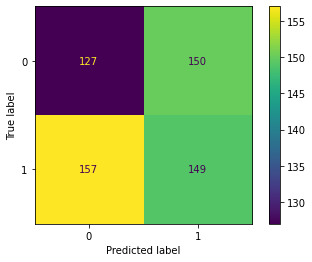

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y[split:], predictions[split:], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                         display_labels=[0,1])
disp.plot()
plt.show()